In [1]:
!hostname

hnl1


In [2]:
# Imports
import os
import numpy as np
import scipy.io as sio
from scipy.signal import buttord, butter, filtfilt, freqz, decimate
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython import get_ipython  # Run magic functions from script
ipython = get_ipython()

In [3]:
def chansets_new():
    chans = np.arange(0, 128)
    chans_del = np.array(
        [56, 63, 68, 73, 81, 88, 94, 100, 108, 114, 49, 43, 48, 38, 32, 44, 128, 127, 119, 125, 120, 121, 126,
         113, 117, 1, 8, 14, 21, 25]) - 1
    chans = np.delete(chans, chans_del)
    return chans

reducedchans = chansets_new() 

In [4]:
channel_idx = np.arange(0, len(reducedchans), 1)

In [5]:
channel_idx_dict = {}
for i in range(len(reducedchans)):
    channel = reducedchans[i]
    idx = channel_idx[i]
    channel_idx_dict[channel] = idx

In [6]:
# Parietal channels to keep similar signs (+ or -) of weights across subjects
poschans = np.array([30, 36, 41, 46])
poschans = np.concatenate((poschans, np.arange(50, 55)))
poschans = np.concatenate((poschans, np.arange(57, 101)))

In [7]:
poschans = [channel_idx_dict[channel] for channel in poschans if channel in channel_idx_dict]

In [8]:
# subjects = ['s100', 's59', 's109', 's110']
subjects = ['s59']
subdes = 's59'
snrlabels = ['low', 'med', 'high']

In [9]:
def baseline(data, wind=range(0, 50)):
    """Simple function to baseline EEG data for ERP calculations

    Inputs:
    data - sample*channel*trial or sample*trial*channel EEG data
    wind - subtracting the mean of this window to re-center EEG data

    Outputs:
    recentered - Re-centered EEG data
    """

    baselines = np.squeeze(np.mean(data[wind, :, :], axis=0))
    recentered = data - np.tile(baselines, (data.shape[0], 1, 1))

    return recentered


def epochsubset(data, newindex, lockindex=None):
    """Reepochs each epoch of EEG data by timelocking each epoch
    "i" to "newindex[i]" with maximum window size available

    Inputs:  
    data - sample*channel*trial EEG data
    newindex - Vector of length "trial"

    Optional inputs:
    lockindex - Sample in which newdata is timelocked
                Default: nanmin(newindex)

    Outputs:  
    newdata - Re-timelocked EEG data          
    lockindex - Sample in which newdata is timelocked
    badtrials - Index of trials where newindex contained nans
    """

    if lockindex is None:
        lockindex = int(np.nanmin(newindex))

    windsize = (np.shape(data)[0] - int(np.nanmax(newindex))) + int(lockindex)

    newdata = np.zeros(
        (int(windsize), int(np.shape(data)[1]), int(np.shape(data)[2])))

    for t in range(0, np.size(newindex)):
        if np.isfinite(newindex[t]):
            begin_index = int(newindex[t]) - lockindex
            end_index = windsize + begin_index
            newdata[:, :, t] = data[begin_index: end_index, :, t]

    badtrials = np.where(np.isnan(newindex))

    return newdata, lockindex, badtrials


# Data save and load locations
mydata_dir = 'ncva_subjects/'
dataloc = mydata_dir + '{0}/{0}_allcleaned.npz'
svd_saveloc = mydata_dir + '{0}/{1}/erp_svd_{0}_{1}_v5_khuong.mat'
# svd_saveloc = '/data10/michael/pdm/exp5data/subjects/training/{0}/{1}/erp_svd_{0}_{1}_v6.mat'
indxloc = mydata_dir + '{0}/{0}_traintestindx.npz'

# Sessions
sessions = []
for i in range(1, 8):
    sessions.extend(['ses%i' % i])

# Percentage variance explained
def perexp(s):
    pexp = np.square(s) / float(np.sum(np.square(s)))
    return pexp

In [11]:
for subdes in subjects:
    print('Loading data for subject %s...' % (subdes))
    # Load EEG Data
    data = np.load(dataloc.format(subdes))

    sr = 1000.  # Make sure it is a floating point number

#     print('Filtering data for subject %s...' % (subdes))
#     filtered = butterfilt(data['eeg'], sr, passband=(
#         1.0, 10.0), stopband=(0.25, 20.0))
#     # filtered = butterfilt(data['eeg'], sr, passband=(
#     #     1.0, 30.0), stopband=(0.25, 40.0), attenuation=(1.0,5.0))
#     filtered2 = butterfilt(data['eeg'], sr, passband=(
#         0.1, 4.0), stopband=(0.01, 8.0))


    from makefilter import makefiltersos
    import scipy.signal as signal
    # low pass filter
    sos, w, h = makefiltersos(sr, 45, 55)
    filtdata = signal.sosfiltfilt(sos, data['eeg'], axis=0, padtype='odd')

    # high pass filter
    sos2, w2, h2 = makefiltersos(sr, 1, 0.25, gs=20)
    filtdatahigh = signal.sosfiltfilt(sos2, filtdata, axis=0, padtype='odd')
    filtered = filtdatahigh.copy()
    

    noiseonsets = data['noiseonsets']
    noiseonsets[noiseonsets < 100] = np.nan
    noiseonsets[noiseonsets > 1000] = np.nan
    datart = data['rt']
    datart[datart < 0] = np.nan

    if any(data['session'] == 'missing'):
        sestrack = np.where(data['session'] == 'missing')[0][0]
        nantrials = np.zeros((480 * np.shape(data['session'])[0]), dtype=bool)
        nantrials[np.arange(0, 480) + 480 * (sestrack)] = True
        noiseonsets[nantrials] = np.nan
        datart[nantrials] = np.nan

    print('Finding cue-locked and response-locked EEG for subject %s...' % (subdes))
    cue_eeg, cue_lockindex, cue_badtrials = epochsubset(
        filtered, noiseonsets)
    resp_eeg, resp_lockindex, resp_badtrials = epochsubset(
        filtered, datart + 1250)

    print('Removing baselines for subject %s...' % (subdes))
    # Response interval, stimulus-locked
    rint_eeg = baseline(filtered[1150:2250, :, :], wind=range(0, 100))

    # Cue interval, stimulus-locked
    cue_eeg = baseline(
        cue_eeg[(cue_lockindex - 100):(cue_lockindex + 500), :, :], wind=range(0, 100))

    # Response interval, response-locked
    resp_eeg = baseline(
        resp_eeg[(resp_lockindex - 1250):(resp_lockindex), :, :], wind=range(0, 100))

    # Load training/test index
    indx = np.load(indxloc.format(subdes))

    # Trials to keep
    keeptrials = np.union1d(np.where(np.isfinite(data['noiseonsets']))[0],
                            np.where(np.sum(data['artifact'], axis=0) != 129)[0])
    keeptrials = np.setdiff1d(keeptrials, cue_badtrials)
    keeptrials = np.setdiff1d(keeptrials, resp_badtrials)

    # Non-artifact training trials
    traintrials = np.union1d(indx['train'], keeptrials)

    sestrack = 0
    for ses in sessions:
        temptrials = np.intersect1d(
            traintrials, np.arange(0, 480) + 480 * (sestrack))
        temptrials2 = np.arange(0, 480) + 480 * (sestrack)
        snrtrack = 0
        svds = dict()  # Run SVD to extract single-trial estimates
        for snr in np.array([0.5, 1.0, 2.0]):
            print('Calculating weights for subject %s, session %s, %0.1f SNR...' % (subdes, ses, snr))
            # Extract trials
            snrtrials = np.where(data['snrvec'] == snr)

            thesetrials = np.intersect1d(temptrials, snrtrials)
            alltrials = np.intersect1d(temptrials2, snrtrials)

            # Channels to keep
            keepchans = np.squeeze(np.array(
                np.where(np.logical_not(np.all(np.squeeze(data['artifact'][:, alltrials]), 1)))))

            # Maintain same extraction across conditions, do this for 3 time-locked
            # intervals
            windows = ['rint', 'cue', 'resp']

#             for w in np.arange(0, 3):
            for w in np.arange(0, 1):
                exec('tempeeg = %s_eeg' % windows[w])

#                 ixgrid1 = np.ix_(np.arange(0, tempeeg.shape[0]),
#                                  reducedchans, thesetrials)  # Use only training data for ERP
                ixgrid2 = np.ix_(np.arange(0, tempeeg.shape[0]),
                                 reducedchans, alltrials)  # Calculate single-trial ERPs in all data

                erp = np.squeeze(np.mean(tempeeg[ixgrid2], axis=-1))

                # Non-statistical SVD
                print('Computing singular value decomposition of %s %s for window %s' % (
                    subdes, ses, windows[w]))
                u, s, v = np.linalg.svd(erp[150:275,:], full_matrices=0)
#                 u, s, v = np.linalg.svd(erp, full_matrices=0)
                # Flip weights in the first component
                if np.sum(v[0, poschans]) < 0.:
                    v[0, :] = -v[0, :]
                    u[:, 0] = -u[:, 0]
                    
                svds['svd_%s_%s' %(windows[w], snrlabels[snrtrack])] = dict()
                svds['svd_%s_%s' % (windows[w], snrlabels[snrtrack])]['erpinput'] = erp
                svds['svd_%s_%s' %(windows[w], snrlabels[snrtrack])]['u'] = u
                svds['svd_%s_%s' %(windows[w], snrlabels[snrtrack])]['s'] = s
                svds['svd_%s_%s' % (windows[w], snrlabels[snrtrack])]['perexp'] = perexp(s)
                svds['svd_%s_%s' %(windows[w], snrlabels[snrtrack])]['v'] = v

                avfw = v[0, :]
                erp_ = np.tensordot(tempeeg[ixgrid2], avfw, axes=(1, 0))
                svds['svd0_%s_%s' %(windows[w], snrlabels[snrtrack])] = np.repeat([avfw], erp_.shape[-1], axis=0)
                svds['st_erp_%s_%s' % (windows[w], snrlabels[snrtrack])] = erp_

                svds['goodchans'] = keepchans + 1
                
                correct_ = data['correct'][alltrials]
                correct_[correct_ == 0] = -1
                svds['st_rt_%s_%s' % (windows[w], snrlabels[snrtrack])] = np.multiply(data['rt'][alltrials], correct_)

                svds['full_eeg_%s_%s' % (windows[w], snrlabels[snrtrack])] = tempeeg[ixgrid2]
                print('Component 1 of svd_%s_%s explained %0.3f%% variance' % (
                    windows[w], snrlabels[snrtrack], perexp(s)[0]))

            snrtrack += 1

        os.makedirs(mydata_dir + '{0}/{1}'.format(subdes, ses), exist_ok=True)
        print(svd_saveloc.format(subdes, ses))
        sio.savemat(svd_saveloc.format(subdes, ses), svds)
        sestrack += 1

Loading data for subject s59...
Finding cue-locked and response-locked EEG for subject s59...
Removing baselines for subject s59...
Calculating weights for subject s59, session ses1, 0.5 SNR...
Computing singular value decomposition of s59 ses1 for window rint
Component 1 of svd_rint_low explained 0.779% variance
Calculating weights for subject s59, session ses1, 1.0 SNR...
Computing singular value decomposition of s59 ses1 for window rint
Component 1 of svd_rint_med explained 0.794% variance
Calculating weights for subject s59, session ses1, 2.0 SNR...
Computing singular value decomposition of s59 ses1 for window rint
Component 1 of svd_rint_high explained 0.931% variance
/data/exp5data/ncva_subjects/s59/ses1/erp_svd_s59_ses1_v5_khuong.mat
Calculating weights for subject s59, session ses2, 0.5 SNR...
Computing singular value decomposition of s59 ses2 for window rint
Component 1 of svd_rint_low explained 0.804% variance
Calculating weights for subject s59, session ses2, 1.0 SNR...
Comp

In [12]:
tempeeg.shape, tempeeg[ixgrid2].shape, avfw.shape, len(ixgrid2), ixgrid2[0].shape, ixgrid2[1].shape, ixgrid2[2].shape

((1100, 129, 3360),
 (1100, 98, 160),
 (98,),
 3,
 (1100, 1, 1),
 (1, 98, 1),
 (1, 1, 160))

In [13]:
sessions = []
for i in range(1, 8):
    sessions.extend(['ses%i' % i])    

snr_idx = []
ses_erp, ses_rt, ses_eeg = [], [], []
ses_v = []
for snr in snrlabels:
    for ses in sessions:
        path = svd_saveloc.format(subdes, ses)
        print(path)
        ses_data = sio.loadmat(path)
        ses_eeg.append(ses_data['full_eeg_rint_%s' %snr])
        ses_erp.append(ses_data['st_erp_rint_%s' %snr])
        ses_rt.append(ses_data['st_rt_rint_%s' %snr])
        snr_idx.extend(ses_data['st_rt_rint_%s' %snr].shape[1]*[snr])
        ses_v.append(ses_data['svd0_rint_%s' %snr])

/data/exp5data/ncva_subjects/s59/ses1/erp_svd_s59_ses1_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses2/erp_svd_s59_ses2_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses3/erp_svd_s59_ses3_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses4/erp_svd_s59_ses4_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses5/erp_svd_s59_ses5_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses6/erp_svd_s59_ses6_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses7/erp_svd_s59_ses7_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses1/erp_svd_s59_ses1_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses2/erp_svd_s59_ses2_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses3/erp_svd_s59_ses3_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses4/erp_svd_s59_ses4_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses5/erp_svd_s59_ses5_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses6/erp_svd_s59_ses6_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/ses7/erp_svd_s59_ses7_v5_khuong.mat
/data/exp5data/ncva_subjects/s59/s

In [14]:
ses_rt_cat = np.hstack(ses_rt)[0]
nan_pos = np.isnan(ses_rt_cat)
ses_rt_cat = ses_rt_cat[~nan_pos] / 1000.
snr_idx = np.array(snr_idx)[~nan_pos]
ses_v0_cat = np.vstack(ses_v)[~nan_pos]

ses_eeg_cat = np.concatenate(ses_eeg, axis=-1)[:1000,:]
ses_eeg_cat = np.swapaxes(ses_eeg_cat, 0, -1)[~nan_pos]
ses_eeg_cat = decimate(ses_eeg_cat, 4)

print(ses_rt_cat.shape, ses_eeg_cat.shape, ses_v0_cat.shape)

(3332,) (3332, 98, 250) (3332, 98)


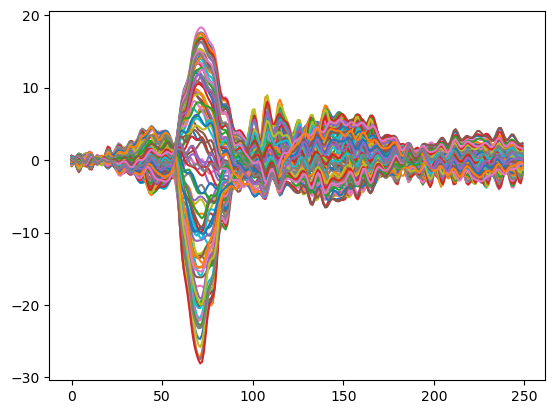

In [15]:
plt.plot(np.mean(ses_eeg_cat, axis=0).T)

In [16]:
for snr in snrlabels:
    idx = snr_idx == snr
    
    trialfinal_train_v0, trialfinal_test_v0, trialfinal_train_eeg, trialfinal_test_eeg, \
    rt_train, rt_test = \
    train_test_split(ses_v0_cat[idx], ses_eeg_cat[idx], ses_rt_cat[idx], test_size=0.2, shuffle=True)
    
    eeg_avg = np.average(trialfinal_train_eeg)
    eeg_std = np.std(trialfinal_train_eeg)
    
    trialfinal_train_eeg = np.array((trialfinal_train_eeg-eeg_avg) / eeg_std)
    trialfinal_test_eeg = np.array((trialfinal_test_eeg-eeg_avg) / eeg_std)
    
    prefix = 'dataset'
    os.makedirs(prefix, exist_ok=True)
    
    with open('%s/v0_train_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, trialfinal_train_v0)

    with open('%s/eeg_train_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, trialfinal_train_eeg)

    with open('%s/rt_train_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, rt_train)

    with open('%s/v0_val_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, trialfinal_test_v0)

    with open('%s/eeg_val_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, trialfinal_test_eeg)

    with open('%s/rt_val_%s_%s.npy' % (prefix, subdes, snr), 'wb') as f:
        np.save(f, rt_test)